<a href="https://colab.research.google.com/github/harrynguyen14/Big-Transfer/blob/main/BigTransfer2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Imports

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

import time

from PIL import Image
import requests
from io import BytesIO

import os
import pathlib

Import Models Trên TF HUB

In [ ]:
#Model ResNet50 trained on ImageNet-21k
model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
module = hub.KerasLayer(model_url)

In [ ]:
model_url = "https://tfhub.dev/google/bit/m-r50x1/ilsvrc2012_classification/1"
imagenet_module = hub.KerasLayer(model_url)

###Data Processing

In [ ]:
dataset_name = 'tf_flowers'
ds, info = tfds.load(name=dataset_name, split=['train'], with_info=True)
ds = ds[0]
num_examples = info.splits['train'].num_examples
NUM_CLASSES = 5

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
#Construct imagenet logit-to-class-name dictionary (imagenet_int_to_str)
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt

imagenet_int_to_str = {}

with open('ilsvrc2012_wordnet_lemmas.txt', 'r') as f:
  for i in range(1000):
    row = f.readline()
    row = row.rstrip()
    imagenet_int_to_str.update({i: row})

--2023-02-10 06:44:03--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 172.253.118.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2023-02-10 06:44:05 (54.6 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]



In [ ]:
#tf_flowers label names
tf_flowers_labels = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [ ]:
# Functions for loading image

def preprocess_image(image):
  image = np.array(image)
  # reshape into shape [batch_size, height, width, num_channels]
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)  
  return image

def load_image_from_url(url):
  """Returns an image with shape [1, height, width, num_channels]."""
  response = requests.get(url)
  image = Image.open(BytesIO(response.content))
  image = preprocess_image(image)
  return image

In [ ]:
MAX_PREDS = 5
# Do not show labels with lower score than this:
MIN_SCORE = 0.8 

def show_preds(logits, image, correct_flowers_label=None, tf_flowers_logits=False):

  if len(logits.shape) > 1:
    logits = tf.reshape(logits, [-1])

  fig, axes = plt.subplots(1, 2, figsize=(7, 4), squeeze=False)

  ax1, ax2 = axes[0]

  ax1.axis('off')
  ax1.imshow(image)
  if correct_flowers_label is not None:
    ax1.set_title(tf_flowers_labels[correct_flowers_label])
  classes = []
  scores = []
  logits_max = np.max(logits)
  softmax_denominator = np.sum(np.exp(logits - logits_max))
  for index, j in enumerate(np.argsort(logits)[-MAX_PREDS::][::-1]):
    score = 1.0/(1.0 + np.exp(-logits[j]))
    if score < MIN_SCORE: break
    if not tf_flowers_logits:
      # predicting in imagenet label space
      classes.append(imagenet_int_to_str[j])
    else:
      # predicting in tf_flowers label space
      classes.append(tf_flowers_labels[j])
    scores.append(np.exp(logits[j] - logits_max)/softmax_denominator*100)

  ax2.barh(np.arange(len(scores)) + 0.1, scores)
  ax2.set_xlim(0, 100)
  ax2.set_yticks(np.arange(len(scores)))
  ax2.yaxis.set_ticks_position('right')
  ax2.set_yticklabels(classes, rotation=0, fontsize=14)
  ax2.invert_xaxis()
  ax2.invert_yaxis()
  ax2.set_xlabel('Prediction probabilities', fontsize=11)

In [ ]:
train_split = 0.9
num_train = int(train_split * num_examples)
ds_train = ds.take(num_train)
ds_test = ds.skip(num_train)

DATASET_NUM_TRAIN_EXAMPLES = num_examples

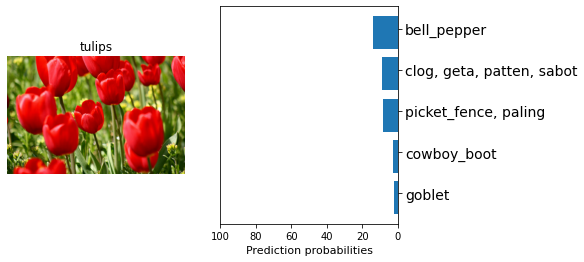

In [ ]:
for features in ds_train.take(1):
  image = features['image']
  image = preprocess_image(image)

  # Run model on image
  logits = imagenet_module(image)
  
  # Show image and predictions
  show_preds(logits, image[0], correct_flowers_label=features['label'].numpy())

Sau khi dự đoán Tulip không phải là 1 class trên ImageNet và model sẽ dự đoán ra 1 loại gần như bell pepper

##Model Build

In [ ]:
class MyBiTModel(tf.keras.Model):
  """BiT with a new head."""

  def __init__(self, num_classes, module):
    super().__init__()

    self.num_classes = num_classes
    self.head = tf.keras.layers.Dense(num_classes, kernel_initializer='zeros')
    self.bit_model = module
  
  def call(self, images):
    # No need to cut head off since we are using feature extractor model
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)

model = MyBiTModel(num_classes=NUM_CLASSES, module=module)

Data Preprocessing

In [ ]:
# Downstream resizing and random cropping details.
IMAGE_SIZE = "=\u003C96x96 px" 
DATASET_SIZE = "\u003C20k examples" 

if IMAGE_SIZE == "=<96x96 px":
  RESIZE_TO = 160
  CROP_TO = 128
else:
  RESIZE_TO = 512
  CROP_TO = 480

if DATASET_SIZE == "<20k examples":
  SCHEDULE_LENGTH = 500
  SCHEDULE_BOUNDARIES = [200, 300, 400]
elif DATASET_SIZE == "20k-500k examples":
  SCHEDULE_LENGTH = 10000
  SCHEDULE_BOUNDARIES = [3000, 6000, 9000]
else:
  SCHEDULE_LENGTH = 20000
  SCHEDULE_BOUNDARIES = [6000, 12000, 18000]

Nếu như bộ nhớ không đủ, thì phải giảm batch size. Đây là một cách để điều chỉnh các tham số liên quan là chia tỷ lệ tuyến tính độ dài lịch trình và tốc độ học tập.

SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

lr = 0.003 * BATCH_SIZE / 512

In [ ]:
# Create data pipelines for training and testing
BATCH_SIZE = 512
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

STEPS_PER_EPOCH = 10

def cast_to_tuple(features):
  return (features['image'], features['label'])
  
def preprocess_train(features):
  # Apply random crops and horizontal flips for all tasks 
  # except those for which cropping or flipping destroys the label semantics
  # (e.g. predict orientation of an object)
  features['image'] = tf.image.random_flip_left_right(features['image'])
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.image.random_crop(features['image'], [CROP_TO, CROP_TO, 3])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

def preprocess_test(features):
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

pipeline_train = (ds_train
                  .shuffle(10000)
                  .repeat(int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH) + 1 + 50)  # repeat dataset_size / num_steps
                  .map(preprocess_train, num_parallel_calls=8)
                  .batch(BATCH_SIZE)
                  .map(cast_to_tuple)  # for keras model.fit
                  .prefetch(2))

pipeline_test = (ds_test.map(preprocess_test, num_parallel_calls=1)
                  .map(cast_to_tuple)  # for keras model.fit
                  .batch(BATCH_SIZE)
                  .prefetch(2))

In [ ]:
lr = 0.003 * BATCH_SIZE / 512 

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

# Fine-tune model
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs= 30,  # TODO: replace with `epochs=10` here to shorten fine-tuning for tutorial if you wish
    validation_data=pipeline_test  # here we are only using 
                                   # this data to evaluate our performance
)

Epoch 1/30
10/10 [==============================] - 55s 3s/step - loss: 0.4390 - accuracy: 0.8240 - val_loss: 0.1206 - val_accuracy: 0.9755
Epoch 2/30
10/10 [==============================] - 11s 1s/step - loss: 0.1882 - accuracy: 0.9479 - val_loss: 0.1296 - val_accuracy: 0.9728
Epoch 3/30
10/10 [==============================] - 11s 1s/step - loss: 0.1451 - accuracy: 0.9637 - val_loss: 0.1147 - val_accuracy: 0.9755
Epoch 4/30
10/10 [==============================] - 11s 1s/step - loss: 0.1236 - accuracy: 0.9646 - val_loss: 0.0923 - val_accuracy: 0.9837
Epoch 5/30
10/10 [==============================] - 11s 1s/step - loss: 0.0952 - accuracy: 0.9711 - val_loss: 0.0962 - val_accuracy: 0.9782
Epoch 6/30
10/10 [==============================] - 11s 1s/step - loss: 0.0713 - accuracy: 0.9789 - val_loss: 0.0852 - val_accuracy: 0.9837
Epoch 7/30
10/10 [==============================] - 11s 1s/step - loss: 0.0710 - accuracy: 0.9787 - val_loss: 0.0815 - val_accuracy: 0.9809
Epoch 8/30
10/10 [==

In [ ]:
export_module_dir = '/tmp/my_saved_bit_model/'
tf.saved_model.save(model, export_module_dir)

In [ ]:
saved_module = hub.KerasLayer(export_module_dir, trainable=True)

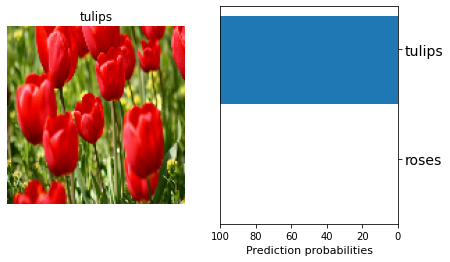

In [ ]:
for features in ds_train.take(1):
  image = features['image']
  image = preprocess_image(image)
  image = tf.image.resize(image, [CROP_TO, CROP_TO])

  # Run model on image
  logits = saved_module(image)
  
  # Show image and predictions
  show_preds(logits, image[0], correct_flowers_label=features['label'].numpy(), tf_flowers_logits=True)